In [2]:
import torch
import torch.utils.data
import torchvision.models as models
from matplotlib import pyplot as plt
import numpy as np
import os
import sklearn as sk
from scipy.io import loadmat
import scipy.io as sio
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import cross_val_score
import sys, os
import pickle
import random
from scipy.stats import wilcoxon, shapiro, ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
## EEG2Code Network
class EEG2CodeV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # first spatial filter
        self.conv2d_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(8, 1),
                                        padding=(0, 0), stride=(1, 1))
        self.relu_1_1 = torch.nn.ReLU()
        self.batch_1 = torch.nn.BatchNorm2d(num_features=16, affine=False)
        self.relu_1_2 = torch.nn.ReLU()
        self.maxpool2d_1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride = (1, 1), padding=(1, 0)) # !!

        #  Second Temporal Filter
        self.conv2d_2 = torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 12),
                                        padding=(0, 0))
        self.batch_2 = torch.nn.BatchNorm2d(num_features=8, affine=False)
        self.relu_2 = torch.nn.ReLU()
        self.maxpool2d_2 = torch.nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 0))
        self.dropout_2 = torch.nn.Dropout(p=0.5)

        # Third layer
        self.conv2d_3 = torch.nn.Conv2d(in_channels=8, out_channels=4, kernel_size=(1, 5),
                                        padding=(0, 2))
        self.batch_3 = torch.nn.BatchNorm2d(num_features=4, affine=False)
        self.relu_3 = torch.nn.ReLU()
        self.maxpool2d_3 = torch.nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 0))
        self.dropout_3 = torch.nn.Dropout(p=0.5)

        # Fourth layer
        self.flatten_4 = torch.nn.Flatten(start_dim = 1)
        self.dense_4 = torch.nn.Linear(in_features=40, out_features=256)
        self.relu_4 = torch.nn.ReLU()
        self.dropout_4 = torch.nn.Dropout(p=0.5)

        # Fifth layer
        self.dense_5 = torch.nn.Linear(in_features=256, out_features=2)
        self.softmax_5 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        
        # layer 1
        #print(x.shape)
        #print("layer 1")
        x = self.conv2d_1(x)
        #print(x.shape)
        #x = self.relu_1_1(x)
        x = self.batch_1(x)
        #print(x.shape)
        x = self.relu_1_2(x)
        #print(x.shape)
        x = self.maxpool2d_1(x)
        #print(x.shape)
        
        # layer 2
        #print("layer 2")
        x = self.conv2d_2(x)
        #print(x.shape)
        x = self.batch_2(x)
        #print(x.shape)
        x = self.relu_2(x)
        #print(x.shape)
        x = self.maxpool2d_2(x)
        #print(x.shape)
        #x = self.dropout_2(x)
        #print(x.shape)
        
        # layer 3
        #print("layer 3")
        x = self.conv2d_3(x)
        #print(x.shape)
        x = self.batch_3(x)
        #print(x.shape)
        x = self.relu_3(x)
        #print(x.shape)
        x = self.maxpool2d_3(x)
        #print(x.shape)
        # x = self.dropout_3(x)
        
        # layer 4
        x = self.flatten_4(x) # !! h = h.view(-1, np.prod(h.size()[1:]))
        #print(x.shape)
        x = self.dense_4(x)
        #print(x.shape)
        x = self.relu_4(x)
        #print(x.shape)
        x = self.dropout_4(x)
        
        # layer 5
        x = self.dense_5(x)
        #print(x.shape)
        #x = self.softmax_5(x)
        
        return x

    # Is dropout handig voor trainen?
    # tijdens trainen dropout aan, en tijdens testen uit met delen door 2 of keer 2
    # Of dropout aan tijdens trainen en tijdens testen, je krijgt een distributie als je dezelfde sample elke keer krijgt
    # distributie piek gebruiken voor early stopping
    # hou verhoudt kans tot distributie

In [8]:
# load the model from disk
model = pickle.load(open('trained_model.sav', 'rb'))
# print(model.state_dict())
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])


Model's state_dict:
conv2d_1.weight 	 tensor([[[[-7.9845e-05],
          [ 2.1497e-01],
          [-4.0038e-01],
          [ 4.0754e-01],
          [ 7.4935e-02],
          [-9.7034e-02],
          [-5.0773e-01],
          [ 1.2266e-01]]],


        [[[-1.4914e-02],
          [ 5.6856e-02],
          [ 3.3310e-01],
          [ 1.8229e-01],
          [-7.6548e-01],
          [-1.1171e-01],
          [ 2.9567e-01],
          [ 5.3040e-02]]],


        [[[ 5.9610e-02],
          [-1.0811e-01],
          [ 3.7058e-01],
          [-6.6415e-01],
          [ 7.2631e-02],
          [ 1.6273e-01],
          [ 3.1318e-01],
          [-2.3271e-01]]],


        [[[ 2.9557e-02],
          [ 3.8840e-02],
          [ 1.3574e-01],
          [-6.9272e-02],
          [-8.0856e-02],
          [-5.3147e-01],
          [ 5.2793e-01],
          [ 9.2367e-03]]],


        [[[ 1.2007e-01],
          [ 1.4838e-01],
          [ 3.8188e-02],
          [ 2.3939e-01],
          [-7.0699e-01],
          [-2.7650e-0

         [[-0.7034,  0.1875,  0.0426, -0.4974, -0.0671]]]])
conv2d_3.bias 	 tensor([ 0.0427, -0.0141,  0.1633,  0.0777])
batch_3.running_mean 	 tensor([ 0.3236, -0.9599, -0.6933, -1.8525])
batch_3.running_var 	 tensor([4.5407, 5.0900, 4.8339, 5.5385])
batch_3.num_batches_tracked 	 tensor(29050)
dense_4.weight 	 tensor([[-0.0839,  0.0675, -0.1761,  ..., -0.0894,  0.0330,  0.1203],
        [-0.2690, -0.1769, -0.0216,  ..., -0.0412, -0.1249, -0.2348],
        [-0.3078, -0.0150, -0.1618,  ..., -0.3612, -0.0881,  0.1581],
        ...,
        [-0.0329,  0.0565, -0.3369,  ...,  0.1541, -0.0241,  0.1891],
        [-0.1889, -0.0907, -0.1368,  ..., -0.0258, -0.2144, -0.2985],
        [-0.1599, -0.1946,  0.1341,  ..., -0.5222,  0.1357, -0.0505]])
dense_4.bias 	 tensor([-0.1071, -0.0050, -0.2324, -0.1349, -0.0453, -0.6385, -0.2091, -0.0950,
         0.2117, -0.0327,  0.0251, -0.2267, -0.1257,  0.0598,  0.0771, -0.0512,
        -0.2018,  0.0443, -0.1660,  0.0030, -0.3657, -0.1215,  0.0319, -0.3718

         -0.1179, -0.0733,  0.0131, -0.0537, -0.0525, -0.0609,  0.0870,  0.0243]])
dense_5.bias 	 tensor([-0.1078,  0.0645])


In [4]:
networkdata = pickle.load(open('results/01/networkdata_01.sav', 'rb'))
test = pickle.load(open('results/01/LDA_acc_epoch_01.sav','rb'))

In [5]:
print(networkdata)
print(test)

[array([0.57752776, 0.5317058 , 0.51949173, 0.5134744 , 0.50642174,
       0.5049929 , 0.50010681, 0.49859399, 0.4946664 , 0.4953742 ,
       0.49142319, 0.49007836, 0.48949748, 0.4884598 , 0.48729041,
       0.48769093, 0.48486453, 0.48388466, 0.48537573, 0.48418617,
       0.48264942, 0.4819431 , 0.48230442, 0.48245177, 0.48025391]), array([0.69747204, 0.73328316, 0.74391401, 0.7495603 , 0.75408375,
       0.75415504, 0.75752479, 0.75938576, 0.76161253, 0.76171201,
       0.7644726 , 0.76420635, 0.76626104, 0.76610911, 0.76726282,
       0.7664063 , 0.76836139, 0.76923406, 0.7683695 , 0.76866394,
       0.76996017, 0.770845  , 0.76983243, 0.769382  , 0.77193415]), array([0.67723358, 0.71243274, 0.72599572, 0.73293865, 0.73735201,
       0.73369217, 0.74198061, 0.73891282, 0.74273413, 0.74327236,
       0.73950481, 0.74138862, 0.74515611, 0.743972  , 0.74278796,
       0.74515611, 0.74714744, 0.74903125, 0.74714744, 0.74773949,
       0.75113022, 0.75080734, 0.74967706, 0.75043058, 0.

In [30]:

all_losses = np.zeros((25,30))
all_accuracy = np.zeros((25,30))
all_testacc = np.zeros((25,30))
all_testloss = np.zeros((25,30))

all_modelacc_e = np.zeros((30))
all_ldaacc_e = np.zeros((30))

all_modelacc_t = np.zeros((30))
all_ldaacc_t = np.zeros((30))
all_reconvacc_t = np.zeros((30))

for i in range(1,31):
    [losses, accuracy, testaccuracy, testloss] = pickle.load(open('results/{}/networkdata_{}.sav'
                                                                  .format(str(i).zfill(2),
                                                                          str(i).zfill(2)),'rb')) 
    all_losses[:,i-1] = losses
    all_accuracy[:,i-1] = accuracy
    all_testacc[:,i-1] = testaccuracy
    all_testloss[:,i-1] = testloss
    
    all_modelacc_e[i-1] = pickle.load(open('results/{}/model_acc_epoch_{}.sav'
                                                                  .format(str(i).zfill(2),
                                                                          str(i).zfill(2)),'rb')) 
    all_ldaacc_e[i-1] = pickle.load(open('results/{}/LDA_acc_epoch_{}.sav'
                                                                  .format(str(i).zfill(2),
                                                                          str(i).zfill(2)),'rb')) 
    all_modelacc_t[i-1] = pickle.load(open('results/{}/model_acc_trial_{}.sav'
                                                                  .format(str(i).zfill(2),
                                                                          str(i).zfill(2)),'rb')) 
    all_ldaacc_t[i-1] = pickle.load(open('results/{}/LDA_acc_trial_{}.sav'
                                                                  .format(str(i).zfill(2),
                                                                          str(i).zfill(2)),'rb')) 
    all_reconvacc_t[i-1] = pickle.load(open('results/{}/reconv_acc_trial_{}.sav'
                                                              .format(str(i).zfill(2),
                                                                      str(i).zfill(2)),'rb')) 


In [132]:
print(np.mean(all_reconvacc_t))

56.766666666666666


In [16]:
print(all_ldaacc_t)

[100. 100. 100.  90. 100. 100. 100.  90. 100. 100. 100.  90. 100.  90.
  90. 100.  90. 100.  90. 100.  80.  90. 100.  90. 100. 100. 100. 100.
 100.  80.]


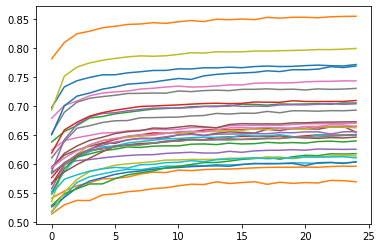

In [20]:

plt.plot(all_accuracy)

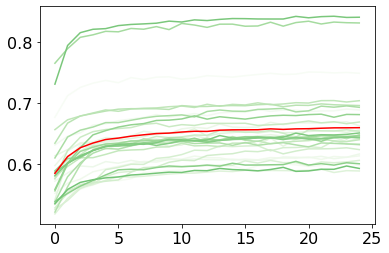

In [49]:


col = plt.cm.Greens(np.linspace(0,0.5,30))

for i in range(30):
    plt.plot(all_testacc[:,i], color=col[i])
    
plt.plot(np.mean(all_testacc,axis=1),color = 'red')

all_testacc = all_testacc*100

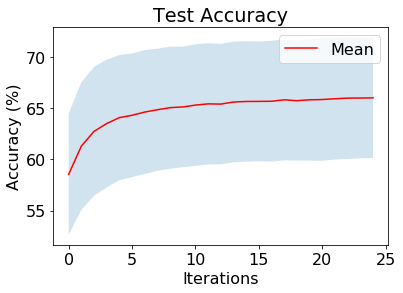

In [28]:
all_testacc = all_testacc*100
plt.rcParams['font.size'] = '16'
plt.plot(np.mean(all_testacc,axis=1),color = 'red', label = "Mean")
#print(np.std(all_testacc, axis=1))
#standard_dev = np.std(all_testacc, axis=1)
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Test Accuracy")


plt.fill_between(range(len(np.mean(all_testacc, axis=1))), 
                 np.mean(all_testacc, axis=1)-np.std(all_testacc, axis=1), 
                 np.mean(all_testacc, axis=1)+np.std(all_testacc, axis=1),  alpha=0.2)

plt.savefig('test_acc_training.pdf',bbox_inches = 'tight')

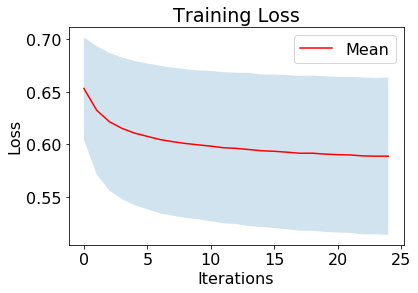

In [25]:
plt.rcParams['font.size'] = '16'
plt.plot(np.mean(all_losses,axis=1),color = 'red', label = "Mean")
#print(np.std(all_testacc, axis=1))
#standard_dev = np.std(all_testacc, axis=1)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")

plt.fill_between(range(len(np.mean(all_losses, axis=1))), 
                 np.mean(all_losses, axis=1)-np.std(all_losses, axis=1), 
                 np.mean(all_losses, axis=1)+np.std(all_losses, axis=1),  alpha=0.2)
plt.savefig('training_loss_training.pdf',bbox_inches = 'tight')

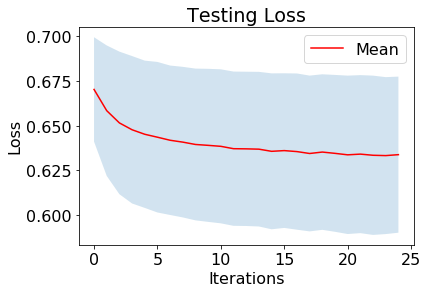

In [26]:
plt.rcParams['font.size'] = '16'
plt.plot(np.mean(all_testloss,axis=1),color = 'red', label = "Mean")
#print(np.std(all_testacc, axis=1))
#standard_dev = np.std(all_testacc, axis=1)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Testing Loss")

plt.fill_between(range(len(np.mean(all_testloss, axis=1))), 
                 np.mean(all_testloss, axis=1)-np.std(all_testloss, axis=1), 
                 np.mean(all_testloss, axis=1)+np.std(all_testloss, axis=1),  alpha=0.2)
plt.savefig('training_loss_test.pdf',bbox_inches = 'tight')

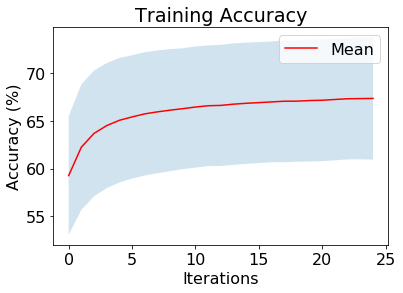

In [31]:
all_accuracy = all_accuracy*100
plt.rcParams['font.size'] = '16'
plt.plot(np.mean(all_accuracy,axis=1),color = 'red', label = "Mean")
#print(np.std(all_testacc, axis=1))
#standard_dev = np.std(all_testacc, axis=1)
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training Accuracy")

plt.fill_between(range(len(np.mean(all_accuracy, axis=1))), 
                 np.mean(all_accuracy, axis=1)-np.std(all_accuracy, axis=1), 
                 np.mean(all_accuracy, axis=1)+np.std(all_accuracy, axis=1),  alpha=0.2)
plt.savefig('training_acc_training.pdf',bbox_inches = 'tight')

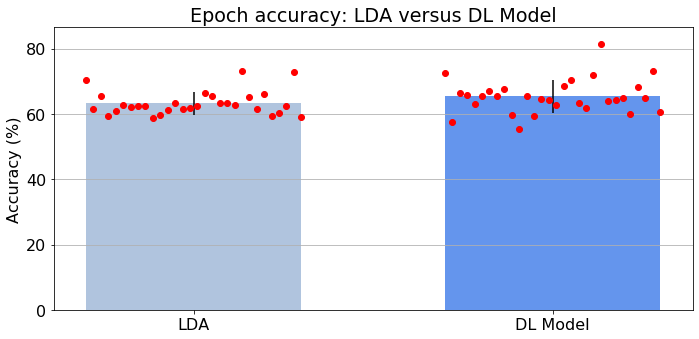

In [12]:
fig = plt.figure(figsize = (10,5))
plt.bar(['LDA','DL Model'],[np.mean(all_ldaacc_e),np.mean(all_modelacc_e)],
        yerr = [np.std(all_ldaacc_e),np.std(all_modelacc_e)],
        color=['lightsteelblue','cornflowerblue'],
        ecolor='black',
        width = 0.6)

plt.ylabel("Accuracy (%)")
plt.grid(b=True,axis='y')


plt.title("Epoch accuracy: LDA versus DL Model")

plt.scatter(np.linspace(-0.3,0.3,30),all_ldaacc_e,zorder = 2,color = 'red')
plt.scatter(np.linspace(0.7,1.3,30),all_modelacc_e,zorder = 2,color = 'red')

plt.tight_layout()
plt.savefig('epoch_comparison.pdf')

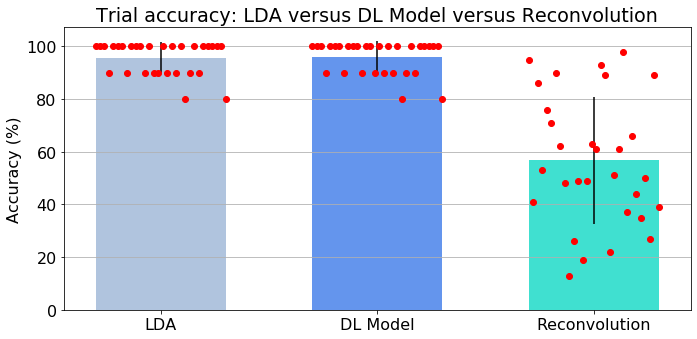

In [13]:
fig = plt.figure(figsize = (10,5))
plt.bar(['LDA','DL Model','Reconvolution'],[np.mean(all_ldaacc_t),np.mean(all_modelacc_t),np.mean(all_reconvacc_t)],
        yerr = [np.std(all_ldaacc_t),np.std(all_modelacc_t),np.std(all_reconvacc_t)],
        color=['lightsteelblue','cornflowerblue','turquoise'],
        ecolor='black',
        width = 0.6)

plt.ylabel("Accuracy (%)")
plt.grid(b=True,axis='y')


plt.title("Trial accuracy: LDA versus DL Model versus Reconvolution")

plt.scatter(np.linspace(-0.3,0.3,30),all_ldaacc_t,zorder = 2,color = 'red')
plt.scatter(np.linspace(0.7,1.3,30),all_modelacc_t,zorder = 2,color = 'red')
plt.scatter(np.linspace(1.7,2.3,30),all_reconvacc_t,zorder = 2, color = 'red')

plt.tight_layout()
plt.savefig('trial_comparison.pdf')

In [19]:
print(np.mean(all_reconvacc_t))
print(np.std(all_reconvacc_t))

56.766666666666666
24.178066276873526


In [16]:
print(wilcoxon(all_ldaacc_e,all_modelacc_e))
print(wilcoxon(all_modelacc_e,all_ldaacc_e))

WilcoxonResult(statistic=87.0, pvalue=0.0027652741969916386)
WilcoxonResult(statistic=87.0, pvalue=0.0027652741969916386)


In [141]:
wc_lda_md = wilcoxon(all_ldaacc_t,all_modelacc_t)
wc_lda_rec = wilcoxon(all_ldaacc_t,all_reconvacc_t)
wc_md_rec = wilcoxon(all_modelacc_t, all_reconvacc_t)
print(wc_lda_md)
print(wc_lda_rec)
print(wc_md_rec)
p_adjusted = multipletests([wc_lda_md[1],wc_lda_rec[1],wc_md_rec[1]], method='bonferroni')
print(p_adjusted)

WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
WilcoxonResult(statistic=4.0, pvalue=2.593837879924086e-06)
WilcoxonResult(statistic=4.0, pvalue=2.5985795409225433e-06)
(array([False,  True,  True]), array([9.51931524e-01, 7.78151364e-06, 7.79573862e-06]), 0.016952427508441503, 0.016666666666666666)


In [129]:
print("LDA epoch",shapiro(all_ldaacc_e))
print("Model epoch",shapiro(all_modelacc_e))

LDA epoch (0.8523250818252563, 0.0006938432343304157)
Model epoch (0.9484228491783142, 0.153366819024086)
